In [1]:
from types import SimpleNamespace
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from pdb import set_trace

import torch
from torch import nn, optim
from torch.nn import functional as F
from dataset import get_data
from training import trainer
from testing import tester

import keras
from keras import layers, models
print(keras.backend.backend())
print(keras.backend.image_data_format())

torch
channels_first


### Congfiuration

In [2]:
args = SimpleNamespace(dataset="mnist")
args.device = "cuda" if torch.cuda.is_available() else "cpu"
args.lr = 5e-4
args.batch = 32
args.epoch = 15
print(args)

namespace(dataset='mnist', device='cuda', lr=0.0005, batch=32, epoch=15)


### mnist

In [3]:
loader = get_data(args.dataset, args.batch)
len(loader.train), len(loader.test)

(1875, 313)

In [4]:
x, y = next(iter(loader.train))
x.shape, y.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [5]:
class Model(nn.Module):
    
    def __init__(self, num_classes=10):
        super().__init__()
        
        self.model = keras.Sequential([layers.Input((1, 28, 28)),
                                       layers.Flatten(),
                                       layers.Dense(200, activation="relu"),
                                       layers.Dense(150, activation="relu"),
                                       layers.Dense(num_classes)])
    
    def forward(self, x):
        return self.model(x)

    def predict(self, x):
        x = self.forward(x)
        pred_y = F.softmax(x, dim=1)
        pred_class = torch.argmax(pred_y, dim=1)
        return pred_class.cpu()

In [6]:
model = Model()
print(model.model.summary())
pred_y = model(x)
pred_y.shape

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200)            │       157,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 188,660 (736.95 KB)

 Trainable params: 188,660 (736.95 KB)

 Non-trainable params: 0 (0.00 B)

None


torch.Size([32, 10])

In [7]:
model = Model().to(args.device)
optimizer = optim.Adam(model.parameters(), lr=args.lr)
loss_fn = nn.CrossEntropyLoss()

In [8]:
model, train_loss = trainer(model, loader.train, args.epoch, 
                            optimizer, loss_fn, args.device)
model.training

100%|██████████| 15/15 [01:56<00:00,  7.75s/it]


False

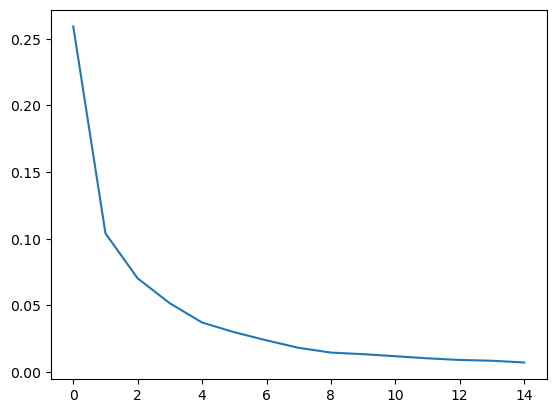

In [9]:
plt.plot(train_loss)
plt.show()

In [10]:
labels, preds = tester(model, loader.test, args.device)
acc = accuracy_score(labels, preds)
print("Test accuracy: ", round(100*acc, 2))

Test accuracy:  97.97


### cifar10

In [11]:
args.dataset = "cifar10"
args.epoch = 25
print(args)

namespace(dataset='cifar10', device='cuda', lr=0.0005, batch=32, epoch=25)


In [12]:
loader = get_data(args.dataset, args.batch)
len(loader.train), len(loader.test)

Files already downloaded and verified
Files already downloaded and verified


(1562, 313)

In [13]:
x, y = next(iter(loader.train))
x.shape, y.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

In [14]:
class Model(nn.Module):
    
    def __init__(self, num_classes=10):
        super().__init__()
        input_layer = layers.Input((3, 32, 32))
        x = layers.Flatten()(input_layer)
        x = layers.Dense(200, activation="relu")(x)
        x = layers.Dense(150, activation="relu")(x)
        output_layer = layers.Dense(num_classes)(x)
        self.model =  models.Model(input_layer, output_layer)
    def forward(self, x):
        return self.model(x)

    def predict(self, x):
        x = self.forward(x)
        pred_y = F.softmax(x, dim=1)
        pred_class = torch.argmax(pred_y, dim=1)
        return pred_class.cpu()

In [15]:
model = Model()
print(model.model.summary())
pred_y = model(x)
pred_y.shape

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 3, 32, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 200)            │       614,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         1,510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 646,260 (2.47 MB)

 Trainable params: 646,260 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

None


torch.Size([32, 10])

In [16]:
model = Model().to(args.device)
optimizer = optim.Adam(model.parameters(), lr=args.lr)
loss_fn = nn.CrossEntropyLoss()

In [17]:
model, train_loss = trainer(model, loader.train, args.epoch, 
                            optimizer, loss_fn, args.device)
model.training

100%|██████████| 25/25 [03:10<00:00,  7.62s/it]


False

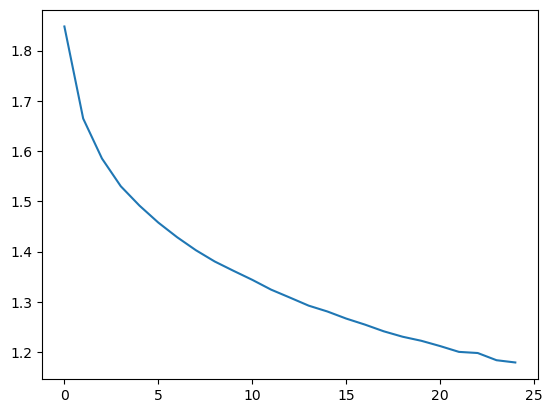

In [18]:
plt.plot(train_loss)
plt.show()

In [19]:
labels, preds = tester(model, loader.test, args.device)
acc = accuracy_score(labels, preds)
print("Test accuracy: ", round(100*acc, 2))

Test accuracy:  51.05
